In [94]:
# !pip install torch
# !pip install mne
# !pip install pandas
# !pip install sklearn
# !pip install seaborn
# !pip install torchsummary
# !pip install heartpy
# !pip install pyhrv
# !pip install hrv-analysis
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import xml.etree.ElementTree as ET
import os
import numpy as np
import pandas as pd
import mne
from matplotlib import pyplot as plt
from datetime import datetime
import scipy.fftpack
import pickle
import glob
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import scipy.signal as signal
import numpy
import heartpy as hp
import time
from joblib import Parallel, delayed
import multiprocessing
from hrvanalysis import get_time_domain_features, get_frequency_domain_features, remove_outliers
from scipy.signal import argrelmax, argrelmin, firwin, convolve,windows
from tqdm.notebook import tqdm

import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
import regex as re
import csv

import neurokit2 as nk


In [95]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print(torch.cuda.device_count())

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
1
Tesla V100-SXM2-32GB-LS
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [96]:
import re

def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)



In [97]:
def count_class(data):
    count0 = 0
    count1 = 0
    count2 = 0
    count3 = 0
    for i in data:
        if i==0:
            count0+=1
        elif i==1:
            count1+=1
        elif i==2:
            count2+=1
        elif i==3:
            count3+=1
        else:
            print(i)
    print("Normal: %d"%count0)
    print("Central Apnea: %d"%count1)
    print("Obstructive Apnea: %d"%count2)
    print("Hypopnea: %d"%count3)
    return count2+count1+count3

def rotate(l, n):
    return l[n:] + l[:n]

In [98]:
def get_subjects(select, all_x = []):
    # select_subject = 2
    normal_x=[]
    normal_y = []
    osb_ap_x=[]
    osb_ap_y = []
    hypop_x=[]
    hypop_y=[]
    cut_window = int(1800 / win_size)
    for select_subject in select:

        select_x = np.array(all_x[select_subject][cut_window:len(all_x[select_subject])-cut_window])
        select_y = np.array(train_y[select_subject][cut_window:len(all_x[select_subject])-cut_window])
#         select_x = np.array(all_x[select_subject])
#         select_y = np.array(train_y[select_subject])
        s_frame = 0
        for i in select_y:
            if i==0:
                normal_x.append(select_x[s_frame])
                normal_y.append(0)
            elif i==2:
                osb_ap_x.append(select_x[s_frame])
                osb_ap_y.append(1)
            elif i==3:
                hypop_x.append(select_x[s_frame])
                hypop_y.append(1)
            elif i==-1:
                hypop_x.append(select_x[s_frame])
                hypop_y.append(-1)
            s_frame += 1
    normal_x = np.array(normal_x)
    osb_ap_x = np.array(osb_ap_x)
    hypop_x = np.array(hypop_x)
    return normal_x,normal_y,osb_ap_x,osb_ap_y,hypop_x,hypop_y



count_o = [0,0,0]
def get_subject_multi_y(select, all_x, all_y):
    cut_window = int(1800 / win_size)
    new_x = []
    new_y = []    
    for select_subject in tqdm(select):
        trigger = False
        temp_y = []
        select_y = np.array(all_y[select_subject][cut_window:len(all_x[select_subject])-cut_window])
        for multi_y in select_y:    
            trigger=False
            if 2 in multi_y:
                count_o[0] = count_o[0] +1
            if 3 in multi_y:
                count_o[1] = count_o[1]+1
                trigger=True
            if 4 in multi_y:
                count_o[2] = count_o[2]+1
                trigger=True
            temp_y.append([1 if d in [2,3,4] else d for d in multi_y])            
#             temp_y.append([1 if d in [2] else d for d in multi_y])            
        select_x = np.array(all_x[select_subject][cut_window:len(all_x[select_subject])-cut_window])
#         if(trigger):
#             continue;
        new_x.extend(select_x)
        new_y.extend(temp_y)      
            
    return np.array(new_x), np.array(new_y)


In [99]:
from sklearn.model_selection import train_test_split
def data_split(normal_x,normal_y):
    normal_x_train, normal_x_test, normal_y_train, normal_y_test = train_test_split(normal_x, normal_y, test_size=0.30, random_state=42)
    normal_x_test, normal_x_val, normal_y_test, normal_y_val = train_test_split(normal_x_test, normal_y_test, test_size=0.50, random_state=42)

    return normal_x_train,normal_y_train,normal_x_test,normal_y_test,normal_x_val,normal_y_val

In [100]:
def running_mean(x, N):
    cumsum = numpy.cumsum(numpy.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def mix_data(ori_data_ppg, ori_data_spo2, ori_data_y):    
    # Mix the datasets (to make it similar to i.i.d)
    idx = np.random.RandomState(seed=42).permutation(len(ori_data_spo2))    
    data_ppg = []
    data_spo2 = []
    data_y = []
    data_ppg_append = data_ppg.append
    data_spo2_append = data_spo2.append
    datay_append = data_y.append
    for i in tqdm(range(len(ori_data_ppg))):
        data_ppg_append(ori_data_ppg[idx[i]])
        data_spo2_append(ori_data_spo2[idx[i]])
        datay_append(ori_data_y[idx[i]])
    data_ppg = np.array(data_ppg)
    data_spo2 = np.array(data_spo2)
    data_y = np.array(data_y)
    return data_ppg, data_spo2, data_y

def resample(list_x, freq):

    re_x = []
    for i, y in enumerate(list_x):  
        re = signal.resample(y,freq) 
        re_x.append(re)
    return np.array(re_x)


def class_balancer(train_ppg, train_spo2,train_y):
    
    (unique, counts) = np.unique(train_y, return_counts=True)
#     print((unique, counts))
    count_normal = counts[0]
    count_apnea = counts[1]

    total_remove = count_normal - count_apnea
    temp_label = train_y.copy()
    delete_index = []
    for i, y in tqdm(enumerate(temp_label), total = temp_label.shape[0]):
        if y == 0 and total_remove > 0:
            total_remove -= 1
            delete_index.append(i)
#     print(len(delete_index))
    train_y = np.delete(train_y, delete_index, axis=0)   
#     train_ppg = np.delete(train_ppg, delete_index, axis=0) 
    train_spo2 = np.delete(train_spo2, delete_index, axis=0) 
    return train_ppg, train_spo2,train_y

def data_reject(train_x,train_y):
    processed_train_x = []
    processed_train_y = []
    no_reject = 0
    for i in tqdm(range(len(train_x))):
        signal = np.array(train_x[i])
        signal = signal.reshape(-1)
        signal = smooth_ppg_signal(signal,sample_rate=256)
        signal = np.array(signal)
        extrema_index = np.sort(np.unique(np.concatenate((argrelmax(signal)[0], argrelmin(signal)[0]))))
        extrema = signal[extrema_index]
        hr = (np.diff(extrema_index[extrema>0])/256.0)
        if(train_y[i] != 1): #Reject only normal case
            if(any(hr) <0.025 or any(hr<0.005)):
                no_reject = no_reject+1
#             print("Reject")
                continue;   
        processed_train_x.append(signal)
        processed_train_y.append(train_y[i])
    print("Reject Total :",no_reject)
    return np.array(processed_train_x),np.array(processed_train_y)

def smooth_ppg_signal(signal, sample_rate=64, numtaps=20, cutoff=[0.5,5]):
    if numtaps % 2 == 0:
        numtaps += 1
    return convolve(signal, firwin(numtaps, [x*2/sample_rate for x in cutoff], pass_zero=False), mode='valid').tolist()

def reject_desat(x_spo2, x_ppg, y):
    delete_index = []
    count = 0
    for i, spo2 in enumerate(x_spo2):
        odi = np.max(spo2) - np.min(spo2)
#         print(np.max(spo2), np.min(spo2))
        if (odi < 3 and y[i]>0):#or (odi > 3 and y_train[i] == 0) :
            delete_index.append(i)
            count+= 1
    x_ppg = np.delete(x_ppg, delete_index, axis=0) 
    x_spo2 = np.delete(x_spo2, delete_index, axis=0) 
    y = np.delete(y, delete_index, axis=0)
    print('total rejected',count)
    return x_spo2, x_ppg, y


In [101]:
def pre_process(dat):
    processed = []
    app = processed.append
    for i in dat:
        b, a = signal.butter(4, [0.1,20],btype='band',fs=hz)
        temp = signal.filtfilt(b, a, i,padlen=0)
#         temp = np.diff(running_mean(temp,64))
        app(temp)
    return np.array(processed)

def Standardize_by_time(train, val, test):
     # Create the Scaler object
    
    scaled_train, scaled_val, scaled_test = [], [], []
    train_sample, time, channels = train.shape[0], train.shape[1], train.shape[2]
    for i in tqdm(range(time)):
        scaler = RobustScaler()
        scaler.fit(train[:, i, :])
        scaled_train.append(scaler.transform(train[:, i, :]))
        scaled_val.append(scaler.transform(val[:, i,  :]))
        scaled_test.append(scaler.transform(test[:, i,  :]))
    train, val, test = np.array(scaled_train), np.array(scaled_val), np.array(scaled_test)
    train = np.swapaxes(train, 0, 1)
    val = np.swapaxes(val, 0, 1)
    test = np.swapaxes(test, 0, 1)
    return train, val, test

def Standardize_by_window(train, val, test):
     # Create the Scaler object
    scaler = StandardScaler()
    train_sample, time, channels = train.shape[0], train.shape[1], train.shape[2]
    scaler.fit(train[:, :, 0])
    scaled_train = scaler.transform(train[:, :, 0])
    scaled_val = scaler.transform(val[:,  :, 0])
    scaled_test = scaler.transform(test[:, :, 0])
#     train, val, test = np.array(scaled_train), np.array(scaled_val), np.array(scaled_test)
    scaled_train = scaled_train.reshape(scaled_train.shape[0], scaled_train.shape[1], 1)
    scaled_val = scaled_val.reshape(scaled_val.shape[0], scaled_val.shape[1], 1)
    scaled_test = scaled_test.reshape(scaled_test.shape[0], scaled_test.shape[1], 1)
    return scaled_train, scaled_val, scaled_test

def reject_artifact(x_spo2, x_ppg, y):
    delete_index = []
    count = 0
    for i, x in enumerate(x_spo2):
        if(np.min(x) < 60):
            delete_index.append(i)
            count+= 1
    x_spo2 = np.delete(x_spo2, delete_index, axis=0) 
    x_ppg = np.delete(x_ppg, delete_index, axis=0) 
    y = np.delete(y, delete_index, axis=0)
    print('total error',count)
    return x_spo2, x_ppg, y

def convert_to_sec_data(train_spo2):
    result = []
    for window in train_spo2:
        sec = []
        for i in range(0, window.shape[0], hz):
#             print(i, window[i])
            sec.append(window[i])
        result.append(sec)
        
    return np.array(result)

def reject_contaminate(x_spo2, x_ppg, y):
    delete_index = []
    count = 0
    for i, gt in enumerate(y):
        if(gt == -1):
            delete_index.append(i)
            count+= 1
    x_spo2 = np.delete(x_spo2, delete_index, axis=0) 
    x_ppg = np.delete(x_ppg, delete_index, axis=0) 
    y = np.delete(y, delete_index, axis=0)
    print('total contaminate',count)
    return x_spo2, x_ppg, y

def convert_contaminate(train_y):
    return [ 1 if y == -1 else y for y in train_y ]

def remove_all_zero_y(all_ppg, all_spo2, all_y):
    delete_index = []          
    
    count = 0
    for i, y in enumerate(all_y):
        if not np.any(y):
            delete_index.append(i)
            count += 1            
    all_y = np.delete(all_y, delete_index, axis=0) 
    all_ppg = np.delete(all_ppg, delete_index, axis=0) 
    all_spo2 = np.delete(all_spo2, delete_index, axis=0)
    print('total zero =', count)
    return all_ppg, all_spo2, all_y

In [102]:
def convert_y_to_hz(all_y, hz):
    
    result = []
    for window in tqdm(all_y):
        y_extend = []
        for i in range(0, window.shape[0]):
#             print(i, window[i])
            y_extend.extend([window[i]] * hz)
        result.append(y_extend)
        
    return np.array(result)

In [103]:
def reshape_time_first(train_x):
    train_x = train_x.reshape(train_x.shape[0],1,-1)
    return train_x

In [104]:
path_dir='./processed_dataset/mesa/mtm/60_stride_30'
hz = 256
win_size = 60
seq = hz*win_size
print(seq)
print("Path Directory on ",path_dir)

15360
Path Directory on  ./processed_dataset/mesa/mtm/60_stride_30


In [105]:
class mesa_data:
    def __init__(self,path= "../nas/NSRR/mesa/datasets/mesa-sleep-dataset-0.5.0.csv",path_harmonized= "../nas/NSRR/mesa/datasets/mesa-sleep-harmonized-dataset-0.5.0.csv"):
        self.path = path
        self.path_harmonized = path_harmonized
        if path is None:
            self.path = "../nas/NSRR/mesa/datasets/mesa-sleep-dataset-0.5.0.csv"
        if path_harmonized is None:
            self.path_harmonized = "../nas/NSRR/mesa/datasets/mesa-sleep-harmonized-dataset-0.5.0.csv"
        self.ahi_list =[]
        self.fname_groundtruth = 0
        self.fname_ppg = 0
        self.metainfo = pd.read_csv(self.path)
        self.mesaid_list = []

        try:
            self.nsrr = pd.read_csv(self.path_harmonized)
            self.harmonized_available = True
        except(e):
            self.harmonized_available = False
        self.all_ppg = []
        self.all_y =[]
        self.converted_all_y = []
    
    def init_signal(self,path_dir='../nas/NSRR/processed/processed_dataset/mesa/mtm/60',hz=256,win_size=60):
        self.path_dir = path_dir
        self.hz= hz
        self.win_size =60
        self.seq = hz*win_size
        print("Sequence Size :",self.seq)
        print("Path Directory on ",self.path_dir)
        
        self.fname_groundtruth = glob.glob(path_dir+'/*_label_*.pckl')
        self.fname_ppg = glob.glob(path_dir+'/*_ppg_*.pckl')
        sort_nicely(self.fname_groundtruth)
        sort_nicely(self.fname_ppg)
        print("Total Files :",len(self.fname_ppg))
    

        for i in tqdm(range(0,len(self.fname_ppg),1)):
            self.all_ppg.append(pd.read_pickle(self.fname_ppg[i]))
            self.all_y.append(pd.read_pickle(self.fname_groundtruth[i]))

    def get_ahi_nsrr(self,mesaid,columns='nsrr_ahi_hp3r_aasm15'):
        assert(self.harmonized_available)
        columns = 'nsrr_ahi_hp3r_aasm15'
        return self.nsrr[self.nsrr['mesaid']==mesaid][columns].to_numpy()[0]
    
    def get_mesaid_list(self):
        self.mesaid_list = []
        for i in self.fname_ppg:
            self.mesaid_list.append(int(i[-9:-5]))
        return self.mesaid_list
    
    def AHI_severe_define(self,ahi_level_list):
        severe_list = []
        for i in range(0,len(ahi_level_list),1):
            if(ahi_level_list[i]>15):
                severe_list.append(1)
            else:
                severe_list.append(0)
        return severe_list
    
    def get_ahi_list(self):
        self.ahi_list =[]
        for k in self.get_mesaid_list():
            self.ahi_list.append(self.get_ahi_nsrr(k))
            
        return self.ahi_list
    
    def get_metainfo_ahi(self):
        self.get_ahi_list()
        (severe,numbe) = np.unique(np.array(self.ahi_list),return_counts=True)
        print("Severity Count",severe,numbe)
        return np.vstack((np.array(self.get_mesaid_list()),np.array(self.ahi_list)))
    def get_filename(self):
        return (self.fname_ppg,self.fname_groundtruth)
    def get_ppg(self,i):
        return self.all_ppg[i]
    def get_y(self,i):
        return self.all_y[i]
    def get_converted_y(self,i):
        return np.array(self.converted_all_y[i])
    def convert_y(self):
        self.converted_all_y = []
        for i in self.all_y:
            temp = []
            for k in i:
                temp.append([1 if d in [2,3,4] else d for d in k])
            self.converted_all_y.append(temp)
        self.converted_all_y = np.array(self.converted_all_y)

In [106]:
# class mesa_signal:
#     def __init__(self,path_dir='../nas/NSRR/processed/processed_dataset/mesa/mtm/60',hz=256,win_size=60):
#         self.path_dir = path_dir
#         self.hz= hz
#         self.win_size =60
#         self.seq = hz*win_size
#         print("Sequence Size :",self.seq)
#         print("Path Directory on ",self.path_dir)
        
#         self.fname_groundtruth = glob.glob(path_dir+'/*_label_*.pckl')
#         self.fname_ppg = glob.glob(path_dir+'/*_ppg_*.pckl')
#         sort_nicely(self.fname_groundtruth)
#         sort_nicely(self.fname_ppg)
#         print("Total Files :",len(self.fname_ppg))
    

        
        

In [107]:
mesa = mesa_data()
mesa.init_signal(path_dir,hz,win_size)

Sequence Size : 15360
Path Directory on  ./processed_dataset/mesa/mtm/60_stride_30
Total Files : 276


  0%|          | 0/276 [00:00<?, ?it/s]

In [108]:
mesa.convert_y()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [122]:
np.unique(np.array(mesa.get_converted_y(33)))

array([0, 1])

In [110]:
np.unique(mesa.get_y(33))

array([0, 2, 3])

In [111]:
test_all_y = []
for k in mesa.get_y(0):
    test_all_y.append([1 if d in [2,3,4] else d for d in k])  

In [112]:
np.array(test_all_y).shape

(1318, 60)

In [113]:
ahi_level =  mesa.AHI_severe_define(mesa.get_ahi_list())
mesaid_arr =mesa.get_mesaid_list()
fname_ppg,fname_groundtruth = mesa.get_filename()

In [ ]:
np.unique(ahi_level,return_counts=True)

In [115]:
from sklearn.model_selection import StratifiedShuffleSplit

In [116]:
skf = StratifiedShuffleSplit(n_splits=5,random_state=42,test_size=0.10)
skf.get_n_splits(mesaid_arr, ahi_level)


5

In [117]:
class _ppg:
    def __init__(self,fname_ppg,fname_groundtruth):
        self.x =[]
        self.y =[]
        self.x_test=[]
        self.y_test =[]
    def get_train(self):
        _x = np.array(self.x)
        _y = np.array(self.y)
        return (_x,_y)
    def get_test(self):
        _x = np.array(self.x_test)
        _y = np.array(self.y_test)
        return (_x,_y)
    def add_train(self,data_x,data_y):
        self.x.append(data_x)
        self.y.append(data_y)
            
    def add_test(self,data_x,data_y):
        self.x_test.append(data_x)
        self.y_test.append(data_y)
    def save_pickle(self,path_dumpp,file_name):
        with open(path_dumpp+file_name+'_x_train.pickle', 'wb') as output:
            pickle.dump(self.x, output,protocol=4)
        with open(path_dumpp+file_name+'_y_train.pickle', 'wb') as output:
            pickle.dump(self.y, output,protocol=4)   
        
        with open(path_dumpp+file_name+'_x_test.pickle', 'wb') as output:
            pickle.dump(self.x_test, output,protocol=4)
        with open(path_dumpp+file_name+'_y_test.pickle', 'wb') as output:
            pickle.dump(self.y_test, output,protocol=4)   

In [118]:
## 4 Features extraction for PPG - PWA/Sys/Dias/Area

from scipy import signal
from scipy.signal import find_peaks
from scipy.signal import argrelextrema
# import ray
# ray.init(ignore_reinit_error=True)
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# @ray.remote
def ppg_extraction(raw_ppg):
    #RR Interval Extraction

    sampling = hz
    ppg = raw_ppg
    ppg_clean = nk.ppg_clean(ppg,sampling_rate=sampling)

    info = nk.ppg_findpeaks(ppg_clean,sampling_rate=sampling)
    peaks = info["PPG_Peaks"]
    rr_interval = (np.diff(peaks)/sampling)*1000

    #Signal Filtering - Find Extrema
    sos = signal.cheby2(2, 0.1, 20, 'hp', fs=hz, output='sos')
    filtered = signal.sosfilt(sos, raw_ppg)
    filtered_ma= moving_average(filtered,hz//2)

    local_minima = argrelextrema(filtered_ma, np.less)[0]
    local_maxima = argrelextrema(filtered_ma, np.greater)[0]


    rm_index=[]
    rm2_index=[]
    for k in range(0,len(np.diff(local_minima)),1):
        if(np.diff(local_minima)[k]<30):
            rm_index.append(k)
            rm2_index.append(k+1)
    sel_min = np.delete(local_minima, rm_index)
    sel_max = np.delete(local_maxima,rm2_index)

    pwa_list = []
    systole_list=[]
    diastole_list=[]
    area_list =[]

    count_min =0
    for mini in sel_min:
        count_min = count_min+1
        count_max = 0
        for maxi in sel_max:
            count_max = count_max+1
            if(maxi>mini):
    #             print(mini , " matched with ", maxi)
                pwa_list.append(filtered_ma[maxi]-filtered_ma[mini])
                systole_list.append(maxi -mini)
                if(count_min+1 <len(sel_min)):
                    diastole_list.append(sel_min[count_min+1]-sel_max[count_max])
                value = 0        
                for i in range(mini,maxi,1):
                    value+=filtered_ma[i]
                area_list.append(value)
                break
                
#     if
#     if len(pwa_list < 5):
#         exit()
#     if len(systole_list <5):
#         exit()
#     if len(rr_interval < 5):
#         exit()
#     if len(area_list <5):
#         exit()
#     if (diastole_list <5):
#         exit()
    
    pwa_list = signal.resample(pwa_list, 60)
    systole_list = signal.resample(systole_list, 60)
    diastole_list = signal.resample(diastole_list, 60)
    area_list = signal.resample(area_list, 60)
    rr_list = signal.resample(rr_interval,60)
    diff_rr_list = signal.resample(np.diff(rr_interval),60)
    diff_pwa_list = signal.resample(np.diff(pwa_list),60)


#     pwa_list = signal.resample(np.difff(pwa_list), 60)
#     systole_list = signal.resample(np.diff(systole_list), 60)
#     diastole_list = signal.resample(np.diff(diastole_list), 60)
#     area_list = signal.resample(np.diff(area_list), 60)
#     rr_list = signal.resample(np.diff(rr_interval),60)
    
    
#     print(rr_list.shape,area_list.shape,diastole_list.shape,systole_list.shape,pwa_list.shape)
    return np.array([np.array(pwa_list,dtype=np.float),np.array(systole_list,dtype=np.float),np.array(diastole_list,dtype=np.float),
                         np.array(area_list,dtype=np.float),np.array(rr_list,dtype=np.float),np.array(diff_pwa_list,dtype=np.float),np.array(diff_rr_list,dtype=np.float)])
#     return np.array([np.array(pwa_list),np.array(systole_list),np.array(diastole_list),
#                      np.array(area_list),np.array(rr_list)])
   


    #Parallel Computing
# def mass_extraction(train_ppg,train_y):
#     prepare_set = []
#     y_set = []
#     count = 0
    
#     for i in range(0,len(train_ppg),1):
#         y_set.append(train_y[count])
#         count +1

#     prepare_set = [ppg_extraction.remote(i) for i in train_ppg]
#     prepare_set = np.array(ray.get(prepare_set))

# #     for i in train_ppg:
# #         try:
# #             prepare_set.append(ray.get(ppg_extraction.remote(i)))
# # #             y_set.append(train_y[count])
# #         except:
# #             print("Errnon")
# #         count = count+1
#     return np.array(prepare_set),np.array(y_set)


def mass_extraction(train_ppg,train_y):
    prepare_set = []
    y_set = []
    count = 0
    
    for i in train_ppg:
        try:
            prepare_set.append(ppg_extraction(i))
            y_set.append(train_y[count])
        except:
            print("PPG : Windows unable to meet expectation")
        count = count+1
       
    return np.array(prepare_set),np.array(y_set)

In [ ]:
k = [_ppg(fname_ppg,fname_groundtruth) for i in range(5)]
f = open("dec_fold_60_stride_30_info.txt", "w")
f.write("Train-Test in 5 folds (Subject Index)")
kfold = 0
for train_index, test_index in skf.split(mesaid_arr, ahi_level):
    print("TRAIN:", train_index, "TEST:", test_index)
    f.write("Fold: {}".format(kfold))
    f.write("TRAIN: {} \n TEST: {}".format(train_index,test_index))
#     X_train, X_test = mesaid_arr[train_index], mesaid_arr[test_index]
#     y_train, y_test = ahi_level[train_index], ahi_level[test_index]
    
    for i in tqdm(range(0,len(train_index),1)):
        _x , _y= mass_extraction(mesa.get_ppg(train_index[i]),mesa.get_converted_y(train_index[i]))
        k[kfold].add_train(_x,_y)
    for i in tqdm(range(0,len(test_index),1)):    
        _x , _y= mass_extraction(mesa.get_ppg(test_index[i]),mesa.get_converted_y(test_index[i]))
        k[kfold].add_test(_x,_y)

    
    kfold=kfold+1

    print(kfold, " done...")

TRAIN: [ 96  89 138 153  13 237 116  79  25  94 200 155  78  74 209  14  39 211
 172 128 257  81 182 187 226 161 152 267 171 136  28  12  62 120  26   8
  53 223  48 177 252 232  55  66 230 216 199 121 174 213  51 250  69 119
  86 265 219 231  11  93  16  85  75  88  18  33 111 246  60 150 167  71
  68  46 147 106 108  49 127 247 144 145 258  92  98 220 197 134  15 212
  21  44 105  19 115 243 262 240 166 207  67   2  57 180  80 210 235 129
  50 107 206 179 273 162  35  41 114 137 168 249 255 125 141  17 236 191
 204 229 274 215 184 181 238 135  99 124  47  43  90 160 203  56  36 158
  97 165  91  83  45 140 164 148 151 202 260 169 193  87  63  20 190 198
   9  24 189  95 275 109 186 253 117  58  73 132 133  54 234 139  64 104
 163 188   0   3 112 143 224 110 242 241  32  30  22 227 218 259  34 178
 173  10 217 222 228 272 270 254  38 123 102 156 261 130  76   5 264 263
 251 239   4 159 205  82 221 103  65  42 131 101 122  31 157 100   6  37
 208  52 201 266 268 245 271 142 149  59  77

  0%|          | 0/248 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

In [124]:
count =0
for i in k:
    i.save_pickle('../nas/processed_dataset/dec_data_60_stride_30_prep/','mesa_fold'+str(count))
    count = count+1

In [ ]:
count

In [37]:
_ppg[0]

TypeError: 'type' object is not subscriptable

In [38]:
_x, _y = k[0].get_train()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


In [31]:
_x.shape

(247,)

In [35]:
_x[0].shape

(623, 7, 60)

In [43]:
_y[0].shape

(623, 60)

In [44]:
np.unique(_y[0],return_counts=True)

(array([0, 1, 2, 3]), array([35806,    13,   151,  1410]))

In [34]:
print(len(all_ppg))
print(len(all_y))

NameError: name 'all_ppg' is not defined

In [75]:
all_ppg[0].shape

(659, 15360)

In [76]:
print(hz*win_size)

15360


In [80]:
# test_range = range(282,312,1)
test_range=range(0,241,1)
len(test_range)

241

In [78]:
# ray.shutdown()

In [79]:
# import ray
# if(ray.is_initialized() == False):
#     ray.init()


In [81]:


#Extract by Subject for AHI Estimation Validation
test_x_sub = []
test_y_sub = []
for i in test_range:
    print(i)
    test_ppg, test_y = get_subject_multi_y([i], all_ppg, all_y)
#     test_y = convert_y_to_hz(test_y, hz)
#     print(test_ppg.shape)
    training_set , training_y= mass_extraction(np.array(test_ppg).reshape(-1,hz*win_size),test_y)
    test_x_sub.append(training_set)
    test_y_sub.append(training_y)

0


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
1


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
2


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
3


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
6


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
8


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
9


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
10


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
12


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
13


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
14


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
17


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
18


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
20


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
25


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
26


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
29


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
31


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
32


  0%|          | 0/1 [00:00<?, ?it/s]

33


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
34


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
35


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
36


  0%|          | 0/1 [00:00<?, ?it/s]

37


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
38


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
42


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
45


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
47


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
48


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
49


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
52


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
57


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
59


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
60


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
61


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
62


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
66


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
67


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
69


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
70


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
71


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
74


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
75


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
76


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
77


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
78


  0%|          | 0/1 [00:00<?, ?it/s]

79


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
80


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
81


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
82


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
85


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
88


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
89


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
90


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

92


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
93


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
94


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

101


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
102


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

105


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
106


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
108


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
109


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
111


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
112


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
113


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
115


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
116


  0%|          | 0/1 [00:00<?, ?it/s]

117


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
118


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
119


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
120


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
123


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
124


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
126


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
127


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
128


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
129


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
132


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
133


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
134


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
135


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
136


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
137


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
140


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
142


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
143


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
144


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
145


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
147


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
148


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
149


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
152


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
153


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
154


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
157


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
158


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
160


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
162


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
163


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
164


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
165


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
167


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
168


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
169


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
171


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
172


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
173


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
175


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
176


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
178


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
180


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
184


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
185


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
188


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
189


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
192


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
194


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
195


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
198


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
199


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
201


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

203


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
206


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
207


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
211


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
212


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
213


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
215


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
217


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
220


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
221


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
222


  0%|          | 0/1 [00:00<?, ?it/s]

223


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
225


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
226


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
228


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
229


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
237


  0%|          | 0/1 [00:00<?, ?it/s]

238


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
239


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation


In [52]:
np.array(test_x_sub).shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(30,)

In [ ]:
test_y_sub[0][0].shape

In [189]:
s0 =[]
sy0 = []
count_s =0
for s in test_x_sub:
    x0 =[]
    y0 =[]
    count_i = 0
    for i in s:
        try:
            print(i.shape)
            x0.append(i)
            y0.append(test_y_sub[count_s][count_i])
        except:
            print(type(i))
        count_i = count_i+1
    s0.append(np.array(x0))
    sy0.append(np.array(y0))
    count_s=count_s+1
s0 = np.array(s0)
sy0 = np.array(sy0)

(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)


(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)

(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)


<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)

<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'None

(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<cla

(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7

(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7

(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)


(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneT

(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(

(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 6

(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 6

(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)


(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [210]:
s0[0].shape

(648, 7, 60)

In [199]:
sy0[0].shape

(648, 60)

In [200]:
test_x_sub = s0
test_y_sub = sy0

In [201]:
test_x_sub[0][0].shape

(7, 60)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


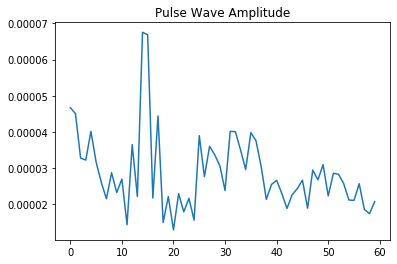

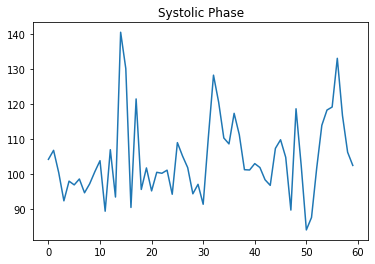

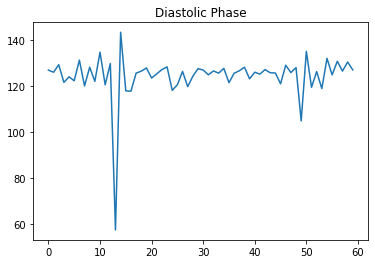

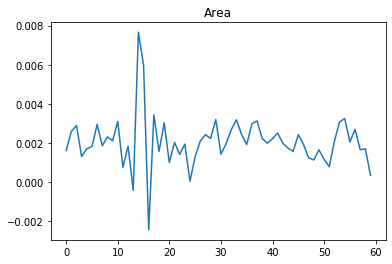

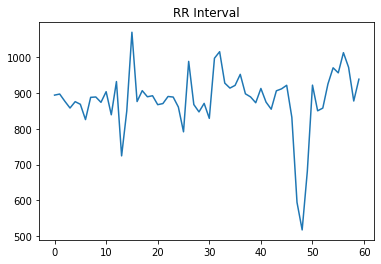

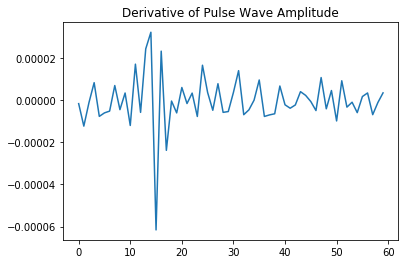

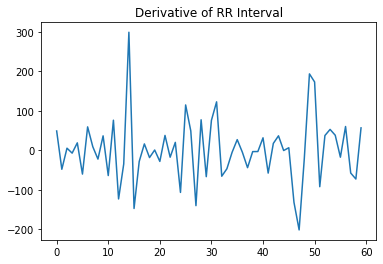

In [83]:
selection_no = 8
window_no = 85

print(test_y_sub[selection_no][window_no])
plt.title("Pulse Wave Amplitude")
plt.plot(test_x_sub[selection_no][window_no,0])
plt.figure()
plt.title("Systolic Phase")
plt.plot(test_x_sub[selection_no][window_no][1])
plt.figure()
plt.title("Diastolic Phase")
plt.plot(test_x_sub[selection_no][window_no][2])
plt.figure()
plt.title("Area")
plt.plot(test_x_sub[selection_no][window_no][3])
plt.figure()
plt.title("RR Interval")
plt.plot(test_x_sub[selection_no][window_no][4])
plt.figure()
plt.title("Derivative of Pulse Wave Amplitude")
plt.plot(test_x_sub[selection_no][window_no][5])
plt.figure()
plt.title("Derivative of RR Interval")
plt.plot(test_x_sub[selection_no][window_no][6])

IndexError: index 1000 is out of bounds for axis 0 with size 582

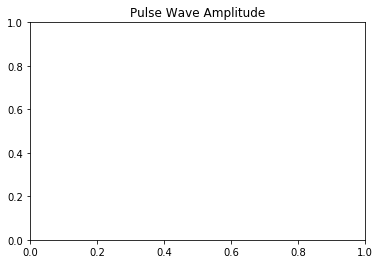

In [84]:
plt.title("Pulse Wave Amplitude")
plt.plot(training_set[1000,0])
plt.figure()
plt.plot(training_y[1000])

In [ ]:
plt.plot(training_set[1000,1])


In [ ]:
training_set.shape

In [85]:
training_set[:,0,:].shape

(582, 60)

In [86]:
y_subset = []
for i in training_y:
    un = np.unique(i,return_counts=True)
    if 1 in un[0] and 0 in un[0]:
        if un[1][1] > 640:
            y_subset.append(1)
            continue;
        else:
            y_subset.append(0)
    elif 1 in un[0]:
        y_subset.append(1)
        continue;
    else:
        y_subset.append(0)

In [42]:
training_x_apnea = []
training_x_normal =[]

for i,y in enumerate(y_subset):
    if(y == 0):
        training_x_normal.append(training_set[i])
    if(y == 1):
        training_x_apnea.append(training_set[i])
training_x_apnea = np.array(training_x_apnea)
training_x_normal =np.array(training_x_normal)

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

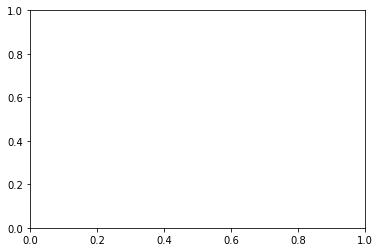

In [43]:

label = ["Normal","Apnea"]
# plt.boxplot(,label=label)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot([training_x_normal[:,0,:].reshape(-1),training_x_apnea[:,0,:].reshape(-1)], showfliers=False)
ax.set_title('Pulse Wave Amplitude')
ax.set_xlabel('Event')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot([training_x_normal[:,1,:].reshape(-1),training_x_apnea[:,1,:].reshape(-1)], showfliers=False)
ax.set_title('Systolic Phase')
ax.set_xlabel('Event')

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

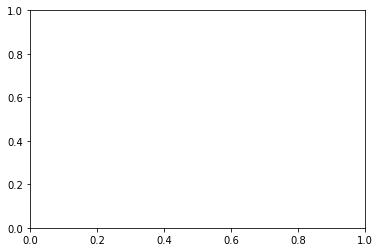

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot([training_x_normal[:,2,:].reshape(-1),training_x_apnea[:,2,:].reshape(-1)], showfliers=False)
ax.set_title('Diastolic Phase')
ax.set_xlabel('Event')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot([training_x_normal[:,3,:].reshape(-1),training_x_apnea[:,3,:].reshape(-1)], showfliers=False)
ax.set_title('Area')
ax.set_xlabel('Event')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot([training_x_normal[:,4,:].reshape(-1),training_x_apnea[:,4,:].reshape(-1)], showfliers=False)
ax.set_title('RR Interval')
ax.set_xlabel('Event')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: S

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

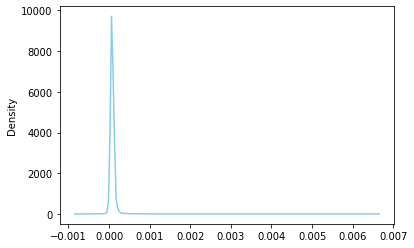

In [45]:
import seaborn as sns
sns.distplot(training_x_normal[:,0,:].reshape(-1),
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1},
            hist=False)
sns.distplot(training_x_apnea[:,0,:].reshape(-1),
                  bins=100,
                  kde=True,
                  color='red',
                  hist_kws={"linewidth": 15,'alpha':1},
            hist=False)

In [ ]:

    
path_dumpp = '../nas/NSRR/processed/pickle_set/mesa_by_subject_'

    
with open(path_dumpp+'_train_val_x_ppg.pickle', 'wb') as output:
    pickle.dump(test_x_sub, output, protocol=4)
with open(path_dumpp+'_train_val_y.pickle', 'wb') as output:
    pickle.dump(test_y_sub, output,protocol=4)
